🥇Goal:

Predict Sunspots using NASA's sunspot data that was recorded every month since the year 1749.

https://www.swpc.noaa.gov/products/solar-cycle-progression

❓ What are Sunspots?

Points on the sun where the magnetic field is about 2500 times greater than that of Earth's. When sunspots are maximum, more solar flares occur causing disruptions in radio comms and power grids and more northern and southern lights appear, heightening geomagnetic storm activity for Earth.

# Setup

## Import libraries

In [ ]:
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras import losses, optimizers, metrics

import json
import os
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

## Load Data

In [ ]:
fpath = '/content/observed-solar-cycle-indices.json'

df = pd.read_json(fpath)

In [ ]:
df.head()

,time-tag,ssn,smoothed_ssn,observed_swpc_ssn,smoothed_swpc_ssn,f10.7,smoothed_f10.7
0,1749-01,96.7,-1.0,-1.0,-1.0,-1.0,-1.0
1,1749-02,104.3,-1.0,-1.0,-1.0,-1.0,-1.0
2,1749-03,116.7,-1.0,-1.0,-1.0,-1.0,-1.0
3,1749-04,92.8,-1.0,-1.0,-1.0,-1.0,-1.0
4,1749-05,141.7,-1.0,-1.0,-1.0,-1.0,-1.0


In [ ]:
df = df.iloc[:, 0:2]
df.columns

Index(['time-tag', 'ssn'], dtype='object')

In [ ]:
len(df)

3304

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3304 entries, 0 to 3303
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   time-tag  3304 non-null   object 
 1   ssn       3304 non-null   float64
dtypes: float64(1), object(1)
memory usage: 51.8+ KB


In [ ]:
df.describe()

,ssn
count,3304.000000
mean,81.822821
std,67.641256
min,0.000000
25%,24.100000
50%,67.750000
75%,122.500000
max,398.200000


## Plot

<Axes: >

<Figure size 800x600 with 0 Axes>

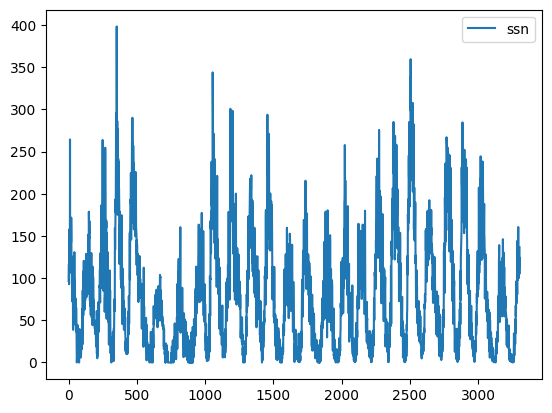

In [ ]:
plt.figure(figsize=(8, 6))
df.plot()

# Preprocessing

## Scale the data

Scaling is a necessary step to ensure all values are consistent on one scale. Here, we're using MinMaxScaler to squeeze the values b/w 0 and 1

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
data = df.iloc[:, 1].values.reshape(-1, 1)
data = scaler.fit_transform(data)

# Prepare Time Windows

Modeling Experiments on:

* Naive Baseline
1. Window=12, Horizon=1
2. Window=24, Horizon=1
3. Window=60, Horizon=12
4. Window=60, Horizon=24
5. Window=60, Horizon=60
5. Window=180, Horizon=180

In [ ]:
BUFFER_SIZE = 1024

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices(data)

We're creating a single-step window, meaning, we're sliding the window by 1 step each time to predict the next step.

However, it makes the model learn better if the data is in a sequence or a wider window to predict another sequence.

Therefore, this problem can also be called sequence-to-sequence prediction

In [ ]:
#ef make_windows(data, input_window, horizon, buffer_size=BUFFER_SIZE):
window_size = 60

dataset = dataset.window(size=window_size + 1, shift=1, drop_remainder=True).flat_map(lambda w: w.batch(window_size + 1))
dataset = dataset.map(lambda x:(x[:-1], x[1:]))
dataset = dataset.shuffle(buffer_size=BUFFER_SIZE)

# Split train/test

In [ ]:
data.shape

(3304, 1)

In [ ]:
BATCH_SIZE = 64

test_size = 0.2
num_samples = data.shape[0]
num_train_samples = int(num_samples * (1 - test_size))
train_ds = dataset.take(num_train_samples).batch(BATCH_SIZE)
test_ds = dataset.skip(num_train_samples).batch(BATCH_SIZE)

In [ ]:
print(f'Train Samples: {num_train_samples}')
print(f'Test Samples:{int(num_samples * test_size)}')

Train Samples: 2643
Test Samples:660


# Model Architecture

## Stacked RNN

In [ ]:
model = models.Sequential([
    layers.Conv1D(filters=32, kernel_size=3, strides=1, padding='causal', activation='relu', input_shape=(window_size, 1)),
    layers.GRU(128, return_sequences=True),
    layers.GRU(64, return_sequences=True),
    layers.Dense(32, activation='swish'),
    layers.Dense(32, activation='swish'),
    layers.Dense(1),
], name='stacked_rnn_w60_h1')

model.summary()

Model: "stacked_rnn_w60_h1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 60, 32)            128       
                                                                 
 gru_2 (GRU)                 (None, 60, 128)           62208     
                                                                 
 gru_3 (GRU)                 (None, 60, 64)            37248     
                                                                 
 dense_3 (Dense)             (None, 60, 32)            2080      
                                                                 
 dense_4 (Dense)             (None, 60, 32)            1056      
                                                                 
 dense_5 (Dense)             (None, 60, 1)             33        
                                                                 
Total params: 102753 (401.38 KB)
Trainable param

In [ ]:
def checkpoint(model_name, filepath='./ts_sunspot'):
  return tf.keras.callbacks.ModelCheckpoint(
    os.path.join(filepath, model_name + '_{val_loss:.4f}.h5'),
    monitor='val_loss',
    save_best_only=True,
    verbose=1)

In [ ]:
model.compile(loss=losses.Huber(),
              optimizer=optimizers.RMSprop(),
              metrics=metrics.MeanAbsoluteError())

model.fit(train_ds,
          epochs=40,
          validation_data=test_ds,
          callbacks=[checkpoint(model.name)])

Epoch 1/40
     42/Unknown - 5s 19ms/step - loss: 0.0073 - mean_absolute_error: 0.0863
Epoch 1: val_loss improved from inf to 0.00353, saving model to ./ts_sunspot/stacked_rnn_w60_h10.00.h5
42/42 [==============================] - 6s 52ms/step - loss: 0.0073 - mean_absolute_error: 0.0863 - val_loss: 0.0035 - val_mean_absolute_error: 0.0578
Epoch 2/40


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


39/42 [==========================>...] - ETA: 0s - loss: 0.0034 - mean_absolute_error: 0.0583
Epoch 2: val_loss improved from 0.00353 to 0.00297, saving model to ./ts_sunspot/stacked_rnn_w60_h10.00.h5
42/42 [==============================] - 2s 35ms/step - loss: 0.0034 - mean_absolute_error: 0.0583 - val_loss: 0.0030 - val_mean_absolute_error: 0.0535
Epoch 3/40
42/42 [==============================] - ETA: 0s - loss: 0.0031 - mean_absolute_error: 0.0562
Epoch 3: val_loss did not improve from 0.00297
42/42 [==============================] - 3s 57ms/step - loss: 0.0031 - mean_absolute_error: 0.0562 - val_loss: 0.0030 - val_mean_absolute_error: 0.0537
Epoch 4/40
41/42 [============================>.] - ETA: 0s - loss: 0.0029 - mean_absolute_error: 0.0547
Epoch 4: val_loss improved from 0.00297 to 0.00239, saving model to ./ts_sunspot/stacked_rnn_w60_h10.00.h5
42/42 [==============================] - 3s 58ms/step - loss: 0.0029 - mean_absolute_error: 0.0547 - val_loss: 0.0024 - val_mean_ab

In [ ]:
!zip -r ts_sunspot_v1.zip ts_sunspot

  adding: ts_sunspot/ (stored 0%)
  adding: ts_sunspot/stacked_rnn_w60_h10.00.h5 (deflated 11%)


## Bidirectional RNN

In [ ]:
model = models.Sequential(name='bidirectional_rnn_w60_h1')
model.add(layers.Conv1D(filters=32, kernel_size=5, strides=1, padding="causal", activation="relu", input_shape=[window_size, 1]))
model.add(layers.Bidirectional(layers.GRU(64, return_sequences=True)))
model.add(layers.Bidirectional(layers.GRU(64, return_sequences=True)))
model.add(layers.Dense(32, activation="swish"))
model.add(layers.Dense(16, activation="swish"))
model.add(layers.Dense(1))

model.compile(optimizer="rmsprop", loss="huber", metrics=["mae"])
model.summary()

Model: "bidirectional_rnn_w60_h1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 60, 32)            192       
                                                                 
 bidirectional_2 (Bidirecti  (None, 60, 128)           37632     
 onal)                                                           
                                                                 
 bidirectional_3 (Bidirecti  (None, 60, 128)           74496     
 onal)                                                           
                                                                 
 dense_9 (Dense)             (None, 60, 32)            4128      
                                                                 
 dense_10 (Dense)            (None, 60, 16)            528       
                                                                 
 dense_11 (Dense)            (None, 60, 1)

In [ ]:
model.compile(loss=losses.Huber(),
              optimizer=optimizers.RMSprop(),
              metrics=metrics.MeanAbsoluteError())

model.fit(train_ds,
          epochs=40,
          validation_data=test_ds,
          callbacks=[checkpoint(model.name)])

Epoch 1/40
     42/Unknown - 8s 29ms/step - loss: 0.0043 - mean_absolute_error: 0.0627
Epoch 1: val_loss improved from inf to 0.00211, saving model to ./ts_sunspot/bidirectional_rnn_w60_h1_0.0021.h5
42/42 [==============================] - 13s 142ms/step - loss: 0.0043 - mean_absolute_error: 0.0627 - val_loss: 0.0021 - val_mean_absolute_error: 0.0470


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/40
42/42 [==============================] - ETA: 0s - loss: 0.0021 - mean_absolute_error: 0.0461
Epoch 2: val_loss improved from 0.00211 to 0.00182, saving model to ./ts_sunspot/bidirectional_rnn_w60_h1_0.0018.h5
42/42 [==============================] - 2s 40ms/step - loss: 0.0021 - mean_absolute_error: 0.0461 - val_loss: 0.0018 - val_mean_absolute_error: 0.0446
Epoch 3/40
40/42 [===========================>..] - ETA: 0s - loss: 0.0019 - mean_absolute_error: 0.0435
Epoch 3: val_loss did not improve from 0.00182
42/42 [==============================] - 2s 38ms/step - loss: 0.0019 - mean_absolute_error: 0.0435 - val_loss: 0.0018 - val_mean_absolute_error: 0.0461
Epoch 4/40
40/42 [===========================>..] - ETA: 0s - loss: 0.0018 - mean_absolute_error: 0.0421
Epoch 4: val_loss improved from 0.00182 to 0.00173, saving model to ./ts_sunspot/bidirectional_rnn_w60_h1_0.0017.h5
42/42 [==============================] - 2s 40ms/step - loss: 0.0018 - mean_absolute_error: 0.0421 - v